# Rasters with GDAL

Last class we got comfortable with using Numpy to manipulate very large arrays. These arrays could be any dimension, but we focused on 1 and 2-dimensional arrays. Today we will work with "rasters", which are 2-dimensional Numpy arrays.

For spatial data like rasters, the amazing workhorse is GDAL. You might have heard of this in the R context from RGDAL. The open-source scientific computing stack is all interlinked. Under the hood, just like with Numpy, GDAL is implemented in very fast C-based code. The python bindings are just a way to access that code from python.

Like all python libraries, we need to import GDAL before we can use it. In the code blcok below, we import it from it's namespace (osgeo). GDAL is grouped with other spatial libraries that collectively are called OSGEO, but for now we will just import GDAL. The `from` command tells us where we are importing it from. We're also going to import a few

In [1]:
from osgeo import gdal
import numpy as np
import os, random
import matplotlib.pyplot as plt

# We can check which version we're running by printing the "__version__" variable
print("GDAL's version is: " + gdal.__version__)
print(gdal)

GDAL's version is: 3.5.0
<module 'osgeo.gdal' from 'c:\\Users\\jajohns\\mambaforge\\envs\\env2023a\\lib\\site-packages\\osgeo\\gdal.py'>


The first thing we are going to do is use gdal to open a raster file. For this to work, you will need to have copied the class Data folder on our shared drive (top image) into your local directory so that it is "Next to" (or more technically "in the same directory as") your Repos directory.

![](images/paste-2.png)

![](images/paste-1.png)

If you organize your files this way, we will now be able to easily use **relative paths** to reference files in the data directory from within code in your Repos dir. The code block below will define this.

Once the data is in the rigbht folder, we will define a variable holding a string that is the path to our raster data. This is remarkably difficult (at least, as measured by how many hours I have wasted because my code pointed to the wrong place). The superior way to manage this is with RELATIVE PATHS. Here, we define the filename, the directory in relative terms, and then join them together using the os functions.

In [2]:
lulc_filename = 'rwanda_lulc_2015.tif'

# the ../ notation means go up one level relative to your current working directory. This gets us outside of the course
# repository and into our Data directory
data_directory = '../../data' 

# Join them together (this will work across operating systems)
lulc_file_path = os.path.join(data_directory, lulc_filename)

print('lulc_file_path', lulc_file_path)

# Also check if the file exists
print("Does the file exist?", os.path.exists(lulc_file_path))

lulc_file_path ../../data\rwanda_lulc_2015.tif
Does the file exist? False


Did it work? No, it didn't (unless you made a lucky mistake!). It's easy to get confused by relative paths, accidentally missing a level or something. In my experience (and looking at what questions we've had come up so far in class), the majority of code errors come from pointing to a "path" that does not exist on your harddrive.

Relative filepaths are defined relative to the current working directory (CWD). One way to trouble-shoot missing paths, then, is to view the current working direcotry:

In [ ]:
print(os.getcwd())

Or to view the absolute path:

In [ ]:
os.path.abspath(data_directory)

Sometimes it can be useful to see what is in the directory you've specified (to help you figure out what's going on if it can't find the file)

In [ ]:
# This will not work! Because our directory is not there!

# contents = os.listdir(data_directory)
# print(contents)

## In-class micro-exercise

In the code block below, I want you to use the os.path.join() approach from earlier to correcly make relative paths pointing to the rwanda_lulc file and use os.path.exists() to show you found it.

In [ ]:
# Class activity workspace

# You might want to use os.path.join(...) and the variables you defined above. Hint, you will need to fix the data_directory location, but to do so, you will need to inspect your folder structure.

In [3]:
# KEY

# Here is the correct path. We had to go up two more levels. This might feel funny, but relative paths are AWESOME.
data_directory = '../../../../data' 

# Join them together (this will work across operating systems)
lulc_file_path = os.path.join(data_directory, lulc_filename)

print('lulc_file_path', lulc_file_path)

# Also check if the file exists
print("Does the file exist?", os.path.exists(lulc_file_path))

lulc_file_path ../../../../data\rwanda_lulc_2015.tif
Does the file exist? True


## GDAL and opening the raster

Now that we know for sure that the file is there, we can use gdal and it's Open function using the DOT notation (technically its a "method" not a function, but you can ignore that. If you're actually curious about object-oriented programming, a method is just a function attached to an object.).

In [4]:
lulc_dataset = gdal.Open(lulc_file_path)
print(lulc_dataset)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000001E7F4C07E70> >


The dataset object holds information about the area and extent of the data, or the geotransform information

In [5]:
geotransform = lulc_dataset.GetGeoTransform()
projection = lulc_dataset.GetProjection()

print('GDAL dataset geotransform', geotransform)
print('GDAL dataset projection', projection)

GDAL dataset geotransform (28.855555555555558, 0.002777777777777778, 0.0, -1.0583333333333333, 0.0, -0.002777777777777778)
GDAL dataset projection GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


IMPORTANT ANNOYING NOTE: in programming, there are different conventions for identifying a place by rows, cols vs. x, y vs. upper-left, lower-right, etc. Numpy is denoted row, col but gdal is denoted X, Y (which flips the order). Just memorize that row = Y and col = X.

In [6]:
n_rows = lulc_dataset.RasterYSize
print('Number of rows in a GDAL dataset', n_rows)

n_cols = lulc_dataset.RasterXSize
print('Number of columns in a GDAL dataset', n_cols)

Number of rows in a GDAL dataset 637
Number of columns in a GDAL dataset 732


Next, get the "band" of the dataset. Many datasets have multiple layers (e.g. NetCDFs). Geotiffs can have multiple bands but often have just 1. For now, grab band 1

In [8]:
lulc_dataset_band = lulc_dataset.GetRasterBand(1)

The band object has information too, like the datatype of the geotiff:

In [9]:
data_type = lulc_dataset_band.DataType
no_data_value = lulc_dataset_band.GetNoDataValue()

print('data_type', data_type)
print('no_data_value', no_data_value)

data_type 1
no_data_value 255.0


Finally, we can get the array from the band as a numpy array:

In [10]:
array = lulc_dataset_band.ReadAsArray()
shape = array.shape

print('Look at the array itself', array)

Look at the array itself [[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


## Plotting a raster

We are now going to use matplotlib. It is basically like ggplot and draws its inspiration from MATLAB notation. By convention, we'll import it into the variable name plt, which is an object that lets us use matplotlib plotting notation.

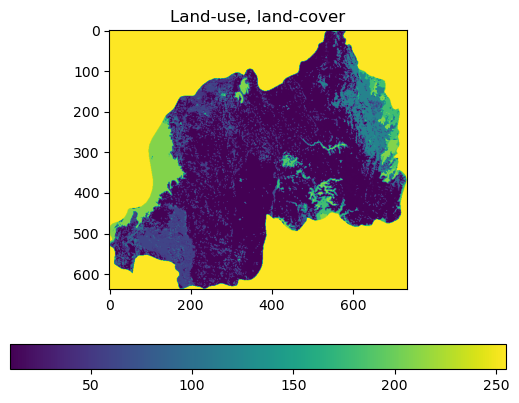

In [11]:
import matplotlib.pyplot as plt

plt.imshow(array)
plt.title('Land-use, land-cover')
plt.colorbar(orientation='horizontal')

# Uncomment this if you want to save it
# plt.savefig('lulc.png', dpi=300) 

plt.show()

This is super ugly for one primary reason: it has scaled the colorbar to the minimum and maximum values, which ends up coloring nearly everything close to the zero value. We're going to crop the values it shoes to not let the outliers define the colorbar range.

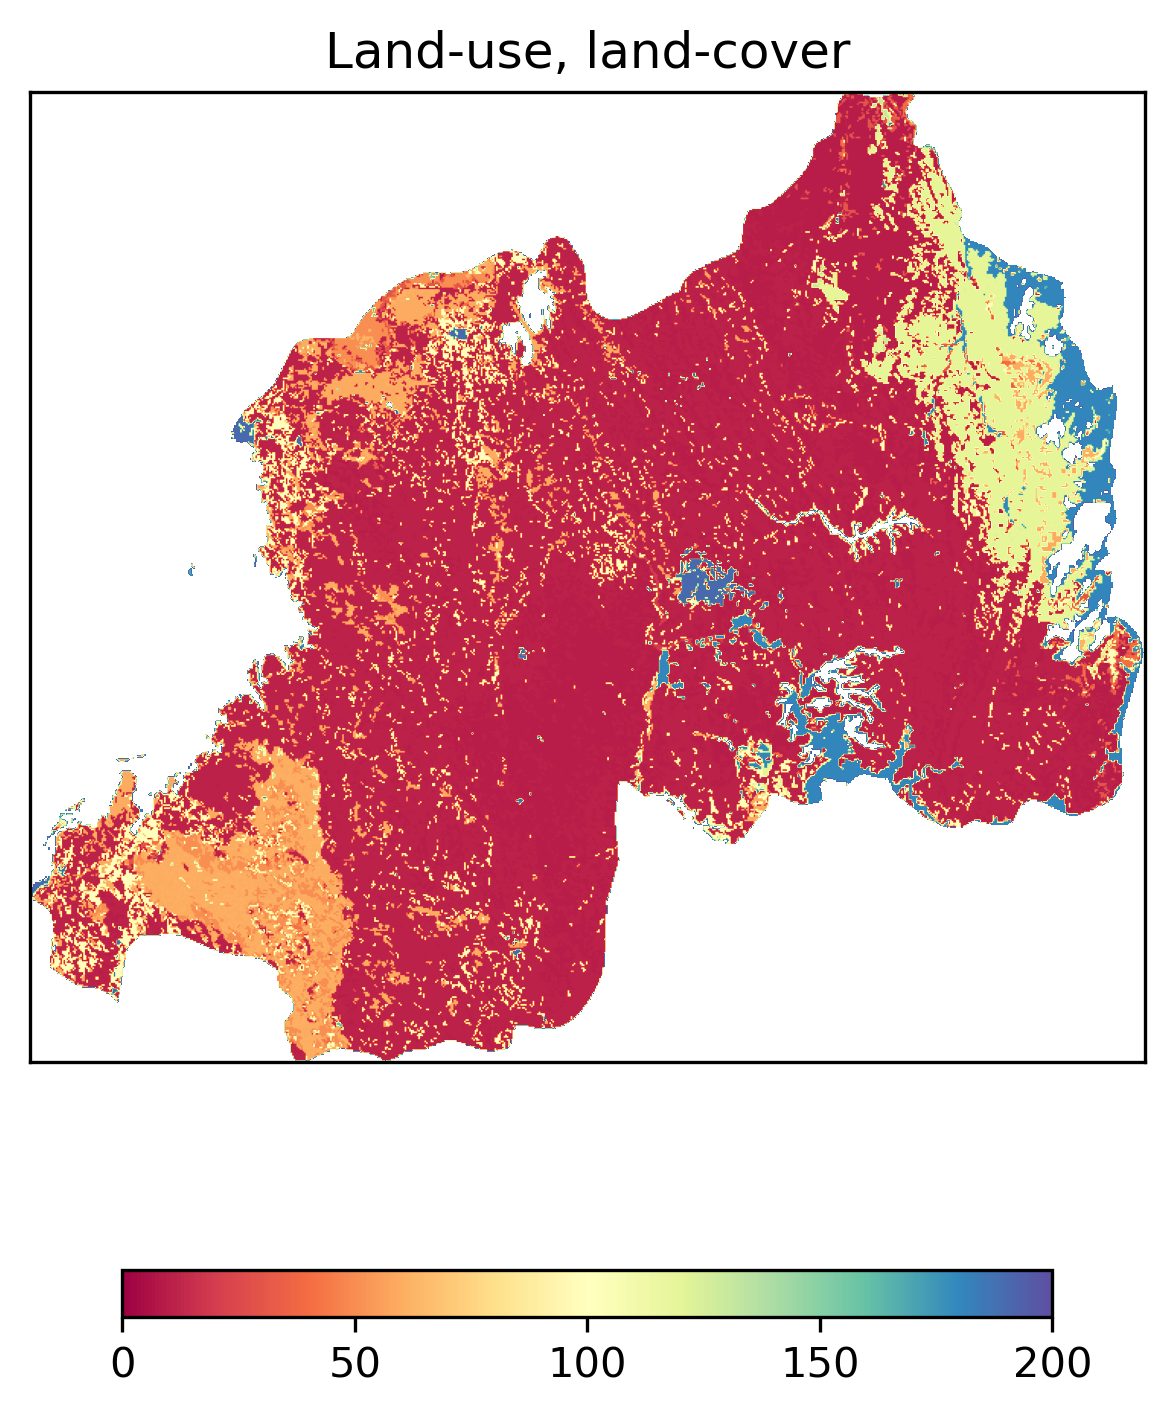

In [12]:
import matplotlib.pyplot as plt

# The second (and often better) plotting method is to use plt to create a figure and one ore more axes.
# This is potentially confusing but is powerful. the Axes object we created (ax) is the plottable area (and there could be lots of axes)
# The figure contains all the axes and is responsible for organizing stuff.

fig = plt.figure(figsize=(8, 6))
fig.set_dpi(300)

ax = fig.add_subplot()

# Set the title of this ax object
ax.set_title('Land-use, land-cover')

# Using the ax we created, we call the imshow function on our array from earlier. This create a new "im" object
im = ax.imshow(array)

# To fix the outlier problem from before, we use the im object to set its limits.
im.set_clim(0, 200)

# Set the cbar to spectral
im.set_cmap('Spectral')

# Get the cmap
cmap = im.get_cmap()
cmap.set_over('white', alpha=1.0)

# Get rid of the numbers on the axes
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# Increase the dpi
fig.set_dpi(300)


# Add the colorbar to the figure. It will generate its values from the im object.
fig.colorbar(im, orientation='horizontal', shrink=0.5)

plt.show()

## Copies versus Views in Numpy

Part of how Numpy arrays are fast is the only ever load or access data when it is needed. This means that if you don't tell numpy to make a copy of something, any new variable will point to the old array. More specifically, this only creates a new pointer to the same block of memory on your computer that holds the array. If we change c_view, c will also be changed. So in the below, c_view only points to the old data in c. This is called a "view" of the array.

In [ ]:
c_view = array

This also means that if you modify array, you will be modifying what you have in c_view.

If you really need a copy in memory, you can use the numpy method copy():

In [ ]:
d = array.copy()

This gives us a NEW array in a new block of memory, so changing array will not change d,

## In-class exercise 2

Here you will use GDAL and numpy to do some highly-optimized raster manipulation.

Using data from Earthstat, I want you to calculate the production per grid-cell of Maize, globally, at "high"-resolution.

The two files you need are in your class data directory (obtained from google drive) named as follows.

```         
maize_HarvestedAreaHectares.tif
maize_YieldPerHectare.tif
```

Use the os.path.join() approach from earlier to correctly make relative paths pointing to the two files.

Open them up as raster using Gdal.

Multiply the HarvestedAreaHectars by YieldPerHectare. This will give you the total production on the grid-cell.

Use numpy to sum up the total production of Maize globally and report that to the class. IMPORTANT NOTE: You will need to use the Numpy function np.nansum(array) or you will end up getting an error about adding no-data values.

In [ ]:
# Exercise workspace

# 

# Here's some starter code if you want to look at the maps
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot()
# ax.set_title('Maize production (tons)')
# fig.set_dpi(300)
# im = ax.imshow(harvested_area_array)

no_data_value -9999.0
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Total maize production globally is 593478850.0 tons


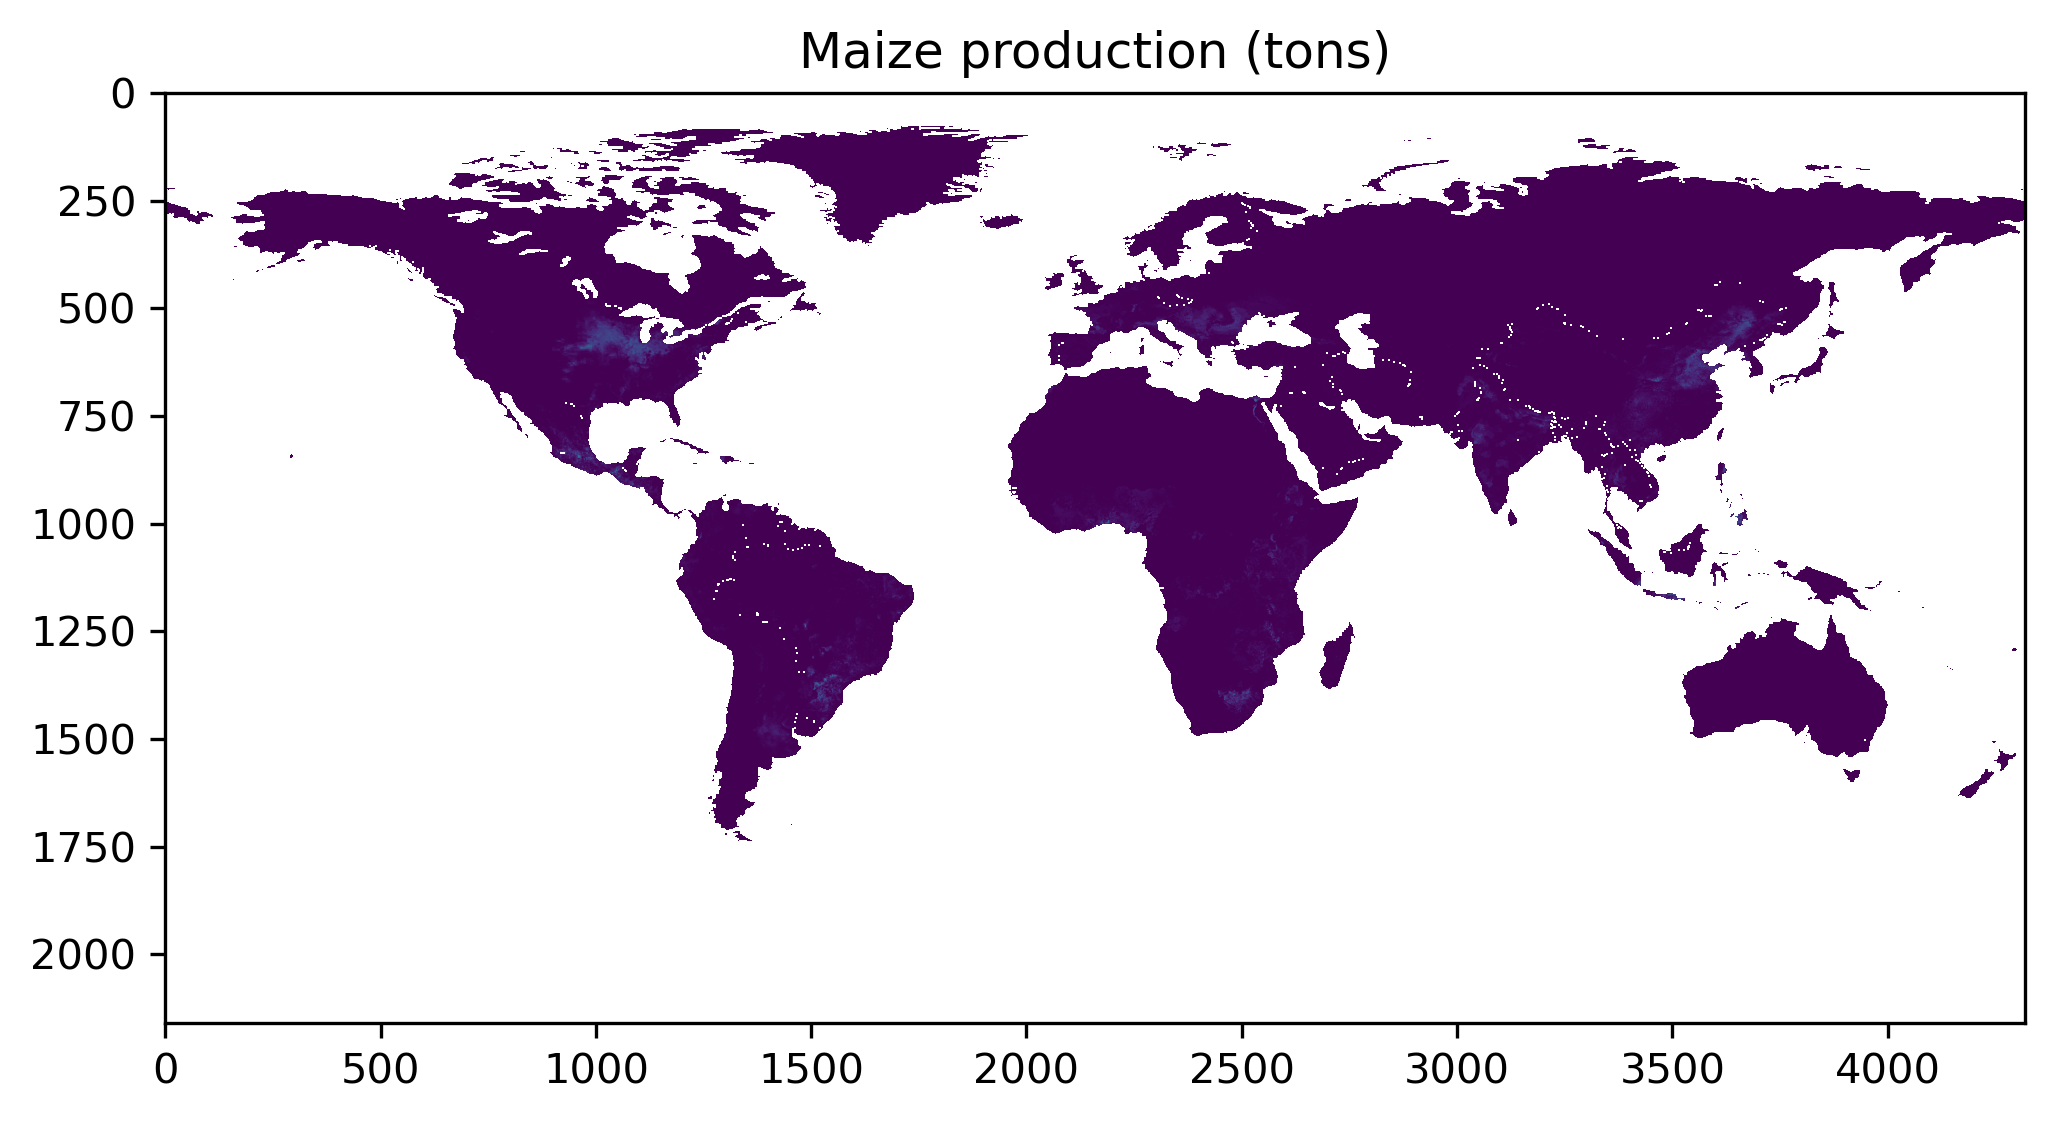

In [13]:
# KEY

# Set the filenames
harvested_area_filename = 'maize_HarvestedAreaHectares.tif'
yield_filename = 'maize_YieldPerHectare.tif'

# Create the paths (by joining with your base data directory)
harvested_area_file_path = os.path.join(data_directory, harvested_area_filename)
yield_file_path = os.path.join(data_directory, yield_filename)

# Open the files
harvested_area_dataset = gdal.Open(harvested_area_file_path)
yield_dataset = gdal.Open(yield_file_path)

# Get the bands
harvested_area_band = harvested_area_dataset.GetRasterBand(1)
yield_band = yield_dataset.GetRasterBand(1)

# Get the no data values and print it. 
no_data_value = harvested_area_band.GetNoDataValue()
print('no_data_value', no_data_value)

# Get the arrays
harvested_area_array = harvested_area_band.ReadAsArray()
yield_array = yield_band.ReadAsArray()

# When gdal calls ReadAsArray(), it now will do the computationally expensive step of reading it all from memory. Also note that when it comes across the value -9999.0, it will save it as Numpy's "not a number": np.nan. 


# Let's actually print one of the arrays
print(harvested_area_array)

# Does this make sense? Why only nans? Think about the shape of the earth and what would be in the "corners" of a flat map of it.

# Multiply them
production_array = harvested_area_array * yield_array

# Plot the result using imshow
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
ax.set_title('Maize production (tons)')
fig.set_dpi(300)
im = ax.imshow(harvested_area_array)

# Print out how many tons of maize are produced globally
print('Total maize production globally is', np.nansum(production_array), 'tons')

Did we get it right?

![](images/paste-3.png)

# Saving a raster to your harddrive

Now that you've created an amazing raster of total maize production, you might want to save it to your harddrive.

To do this, we're first going to define a new filename for our output file. In the code below, + concatenates things. Str() makes the number a string.

In [ ]:
output_filename = 'maize_production.tif'
output_file_path = os.path.join(data_directory, output_filename)

Create a new file at that filename location using the attributes we used above. Notice that we flipped n_cols and n_rows from how numpy would have wanted it. Note that this is an **empty** raster. We haven't written anything to it yet, but we have defined the size and shape of it.

In [ ]:
# First we get some of the key output information from the input raster
n_rows = harvested_area_dataset.RasterYSize
n_cols = harvested_area_dataset.RasterXSize
geotransform = harvested_area_dataset.GetGeoTransform()
projection = harvested_area_dataset.GetProjection()

data_type = harvested_area_band.DataType
output_band = 1

output_dataset = gdal.GetDriverByName('GTiff').Create(output_file_path, n_cols, n_rows, output_band, data_type)

Next we set dataset-level information. Here we're just using what we got from the input raster, defined above.

In [ ]:
output_dataset.SetGeoTransform(geotransform)
output_dataset.SetProjection(projection)

Now get a band from our new dataset on which we'll write our array.

In [ ]:
output_band = output_dataset.GetRasterBand(1)

Do the array writing

In [ ]:
output_band.WriteArray(production_array)

Set any final band-level information

In [ ]:
output_band.SetNoDataValue(no_data_value)

Finally, and very importantly, clean up after yourself. It wont actually write until the resources in memory have been released.

In [ ]:
production_array = None
output_band = None
output_dataset = None

# Real-world example: calculating the potential yield of maize on land that is currently forests in Rwanda

Now that we know how to open, manipulate, and save rasters, we can do some real-world analysis. We're going to calculate the potential yield of maize on land that is currently forests in Rwanda. This might be relevant to, for instance, a regression you would do on household data and whether individuals are likely to cut down their forests to plant maize.

But let's look at these two files in QGIS. The easiest way to load them into QGIS, in my opinion, is to drag the raster file from your file explorer onto QGIS.

What we see is not super pretty because we need to modify the colorbar.

![](images/paste-4.png)

## Double-click the layer you added to bring up its properties. Then select the Symbology tab on the left.

![](images/paste-8.png)

## Choose a colorbar you like. Ensure the min-max values are set.

![](images/paste-9.png)

## This looks a little better

![](images/paste-10.png)

## Now add the Rwanda LULC map you loaded earlier

-   It will now show up in the Layers menu

    -   Note that only the topmost checked layer will be displayed on top, covering other things.

    -   Scroll to Rwanda

![](images/paste-12.png)

## We have several visualization problems

-   First, there are very low maize yields in the area, and so they're almost the lightest color.

    -   Adjust the maximium of the colorbar to \~1000 so you can see the variation

-   Second, these two rasters are at very different resolutions!

![](images/paste-14.png)

Any raster-math we do on them will either fail or (worse) succeed at producing nonsense. This is because the underlying numpy arrays are not representing the same part of earth at the same resolution. We will need to do two things first: **clip** and **reproject** one of the layers to match the other.

## Clip

-   In QGIS, Find the command Clip Raster by Extent.

![](images/paste-16.png)

-   This will bring up a Window to launch the tool.

-   Set the Input layer as the Maize layer (this is the one we will clip to be smaller)

-   Set the Clipping Extent to match the Rwanda LULC map.

![](images/paste-17.png)

## The Clipped map doesn't cover all of the LULC!

-   If you thought data cleaning was hard on tabular data...

![](images/paste-21.png)

-   There are tons of ways to fix this in QGIS, but we're actually going to go back to Python to harness the power of a fun new library: Pygeoprocessing.

## Reprojection

-   In QGIS, Find the raster Warp command.

![](images/paste-15.png)

## Pygeoprocessing

-   Pygeoprocessing is a python library that is built on top of GDAL. It is a little more user-friendly and has some nice features.
-   We are going to use the align_and_resize_raster_stack() function.
    -   But, how do we know what to input into this function?
        -   Let's inspect it.
        -   Put your cursor on `align_and_resize_raster_stack` in the code block below and press F-12. Your computer might not access the Function keys automatically (instead overwriting it with some media player nonsense or the like), so you might have to find the Fn button to hold at the same time (this is switchable).

In [ ]:
import pygeoprocessing 

pygeoprocessing.align_and_resize_raster_stack

This will bring you straight to the function that you installed via Mamba! It will have extensive documentation.

![](images/paste-22.png)

In [ ]:
# Redefine these, just to be safe
yield_file_path = os.path.join(data_directory, yield_filename)
lulc_file_path = os.path.join(data_directory, lulc_filename)

# Define some new paths to store the aligned and clipped files
yield_aligned_file_path = os.path.join(data_directory, 'yield_aligned.tif')
lulc_aligned_file_path = os.path.join(data_directory, 'lulc_aligned.tif')

# Configure the paths into lists (this helps the function generalize to MANY files)
base_raster_path_list = [yield_file_path, lulc_file_path]
target_raster_path_list = [yield_aligned_file_path, lulc_aligned_file_path]

# Create a list as long as the above with the resampling for each respective layer. There's Much more to discuss here
# but for now we'll just use bilinear
resample_method_list = ['bilinear', 'bilinear']

# Next decide which area all the layers will be clipped to. Intersection means it will just be the ones that overlap.
bounding_box_mode = 'intersection'

# Decide which of the base_rasters should define the resolution and projection 
# of the output data. For us, we want it to be the resolution of the LULC map, which is 
# in the second position of the list (index 1)
raster_align_index = 1

# Finally, we need to set the desired pixelsize the data will be resampled to.
target_pixel_size = (0.000833333333333333, -0.000833333333333333)

pygeoprocessing.align_and_resize_raster_stack(base_raster_path_list, target_raster_path_list, resample_method_list,
        target_pixel_size, bounding_box_mode, 
        raster_align_index=raster_align_index)

## When this first worked for me, I almost cried

Seriously. 

We'll learn more about this package soon.

The key element now is that each of the aligned files has exactly the same resolution and extent, which lets us do raster math on them super easily because for any for any range of row-columns, the values are representing the same place on earth.

But for now, let's load them up in QGIS.
